<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import os                # operating system interfaces 

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Visualization & graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import deepchem as dc

# Machine Learning: randomized decision trees
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics  import accuracy_score

from rdkit import Chem               # RDKit libraries for chemistry functions
from rdkit.Chem import Draw          # Drawing chemical structures
from rdkit.Chem import PandasTools   # Manipulating chemical data
from rdkit.Chem import Descriptors   # Calculate molecular descriptors
from rdkit.Chem import rdmolops      # Additional molecular properties
from rdkit.Chem import AllChem       # Morgan (Circular) fingerprints

from rdkit.Chem.Draw import IPythonConsole           # visualizing structures
from rdkit.ML.Descriptors import MoleculeDescriptors # molecular descriptors
from deepchem.utils.evaluate import Evaluator

Parsing Experimental Dataset
---------------

Dataset is available in the `Github` repository. In order to read in the data, we will use the `pandas` data analysis library. The data is in CSV format and contains SMILES strings, measured $\text{IC50}$ and $K_i$, and a number of other experimental measurements and molecular properties. 



In [63]:
# Dataset address
url = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_4OE.csv"

# Load Dataset
df = pd.read_csv(url, encoding="unicode_escape")

# Visualize first 5 rows
df.head(5)

,External_ID,Molecule SMILES,First Sample Reg. Date,SAU Gyr IC50 (µM),SAU Gyr Ki (µM),Sau516 MIC (µg/ml),Sau516 MIC (µM),Mean Human Prot binding (% free),Mean LogD,Determination of pKa HA1,Determination of pKa HA2,Determination of pKa B1,Determination of pKa B2,Sirius pKa
0,AZ1001,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)[N+](=O)[O-],6/10/2002,>400,NaN,>64,NaN,NaN,NV,NaN,NaN,NaN,NaN,NaN
1,AZ1002,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N+](=O)[O-])Br,8/16/2002,>50,NaN,>64,NaN,NaN,>4,NaN,NaN,NaN,NaN,NaN
2,AZ1003,CCOC(=O)c1cc(nc(c1C#N)N2CCC(CC2)NC(=O)c3cc(c([nH]3)C)Br)C,8/16/2002,7.14,NaN,>64,NaN,NaN,>3.66,NaN,NaN,NaN,NaN,NaN
3,AZ1004,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)C#N)Br,8/16/2002,9.93,NaN,>64,NaN,NaN,>3.13,NaN,NaN,NaN,NaN,NaN
4,AZ1005,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3ccc4ccccc4n3)Br,8/16/2002,3.31,NaN,>64,NaN,NaN,>4.07,NaN,NaN,NaN,NaN,NaN


To get a quick glimpse of the dataset, lets calculate e.g. the number of ligands, the chemical space variability and the range of experimentally measured affinities.

In [64]:
print("Number of molecules on dataset: %i" % (df['Molecule SMILES'].count() + 1)) # Number of non-NA/NaN rows
print("Number of IC50 values: %i" % (df['SAU Gyr IC50 (µM)'].count() + 1))        # Number of non-NA/NaN rows
print("Number of Ki values: %i" % (df['SAU Gyr Ki (µM)'].count() + 1))            # Number of non-NA/NaN rows

Number of molecules on dataset: 982
Number of IC50 values: 982
Number of Ki values: 445


SMILES
---------

The only two fields that are useful to our model are the molecular SMILES and the experimental $\text{IC50}$ and $K_i$. First thing to do is to process the SMILES strings with the `RDKit` module. The SMILES can be converted to a `Mol` object, with bond connectivity and molecular properties. In `RDKit` the majority of the basic molecular functionality is found in module `rdkit.Chem`.


### A bird's eye view of the SMILE set.

Text(0, 0.5, 'probability')

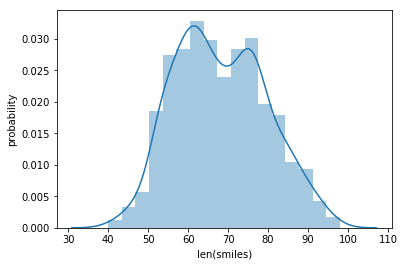

In [65]:
smiles_lens = [len(sm) for sm in df['Molecule SMILES']]
sns.distplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

### Process SMILES

In [0]:
# Setup
pp = pd.DataFrame()                                              # New dataframe 
pp[['ID','Smiles']] = df[['External_ID','Molecule SMILES']]      # Rename headers
pp['ProblematicSmiles'] = pd.Series()                            # Create a new column for SMILES \
                                                                 # that can't be parsed with RDKit

In [0]:
# Some of the SMILE strings will not be parsed by RDKit \
# it is reasonable to expect artifacts from the csv file encoding \
# or errors on the dataset

def smile2mol(smile):
    '''Convert SMILES string to 
       RDKit Mol obj, if the conversion
       fails then return "None"
    
       Keyword arguments:
       smile -- SMILE string
    '''
    try:
        mol = Chem.MolFromSmiles(smile)
    except:
        return None
    else:
        return mol

In [68]:
# Convert SMILES to Mol objects 
pp['Molecule'] = pp['Smiles'].apply(lambda x: smile2mol(x))

RDKit ERROR: [03:11:54] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3ncc(s3)C=O)Cl)Cl'
RDKit ERROR: [03:11:54] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OCC=C)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [03:11:54] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [03:11:54] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OC)C(=O)NC)Cl)Cl'
RDKit ERROR: [03:11:54] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NC)Cl)Cl'
RDKit ERROR: [03:11:54] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4nccn4COC)Cl)Cl'
RDKit ERROR: [03:11:54] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4[nH]ccn4)Cl)Cl'
RDKit ERROR: [03:11:54] SMILE

We can see there are indeed problematic SMILES. When copying and pasting those strings on RDKit directly, I realized the error can be fixed if the string `NC\2CCN` are replaced with `NC2CCN`. This is an _ad-hoc_ solution, that should be made automatic.

In [69]:
# Count problematic SMILES
problematics = [ k for k,v in enumerate(pp['Molecule']) if v is None ]

# Flags these SMILES in the working dataframe
pp['ProblematicSmiles'] = pp['Smiles'].loc[problematics]
  
# Fix SMILES
for sm in range(len(problematics)):
    # problematic SMILE row number
    ix = problematics[sm]  
    
    # Replace character "\2" with "2"
    pp['Smiles'] = pp['Smiles'].str.replace('\2','2', regex=True)
    
    # Redo smile2mol conversion
    pp['Molecule'] = pp['Smiles'].apply(lambda x: smile2mol(x))
    
# Check all went smooth
if not pp['Molecule'].isnull().all().all():
    print("Hey!!! It's FIXED :-)")

Hey!!! It's FIXED :-)


Molecular Descriptors
------------------

The next step should be to translate each compound into a vectorial format that can be understood by statistical learning techniques, e.g. _random forest_, or _neural networks_. `RDKit` molecular descriptors, e.g. molecular weight, atom partial charges, etc, are a way to transform the chemical information containd in the SMILE string into a feature vector. This process is commonly called __featurization__.

*Note: add also Morgan fingerprints.*

### Compute Descriptors

In [0]:
# Molecular descriptors can be obtained from \
# the Mol objects using rdkit.ML.Descriptors.MoleculeDescriptors module

descriptors = list(np.array(Descriptors._descList)[:,0])                        # descriptor list
ccalculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors)    # calculating descriptors

In [0]:
# Make is easier to identify errors or \
# problematic values, e.g infity descriptor values
def computeDescriptors(mol, ccalculator):
    '''Calculate Molecular descriptors from 
       RDKit Mol object, if the calculation
       fails then return "None"
    
       Keyword arguments:
       mol -- RDKit Mol object
    '''
    try:
        features = np.array(ccalculator.CalcDescriptors(mol))
    except:
        return None
    else:
        if not np.all(np.isfinite(features)):
            print("Caution! Infinite value")
            return None
        else:
            return features

In [72]:
# Selecting only non-null molecules 
pp = pp[ pp["Molecule"].notnull() ]

# Mapping descriptors with molecules
ff = lambda x: computeDescriptors(x, ccalculator)
pp['Descriptors'] = pp['Molecule'].map(ff)

# Flag problems
problematics = pp["Descriptors"].isnull()
print("{} molecules failed to get descriptors".format(problematics.sum())) 

0 molecules failed to get descriptors


In [73]:
# Convert descripor list to dataframe
tmpdess = pp["Descriptors"].apply(pd.Series)

# Make headers the descriptor names
tmpdess = tmpdess.rename(columns = lambda x : descriptors[x])

# Check first 5 rows
tmpdess.head(5)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.198481,-0.435597,12.198481,0.013283,0.623001,384.223,369.103,383.055195,132.0,0.0,0.311075,-0.350740,0.350740,0.311075,1.400000,2.120000,2.720000,1.606288,782.714558,17.974327,13.037493,14.549351,11.952397,7.646576,8.402505,5.682961,6.468125,4.062271,4.755185,2.799838,3.112547,-2.32,5.332598e+05,17.501340,7.283006,3.853433,152.831853,15.200677,10.847038,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.517532,-0.411106,12.517532,0.011515,0.550709,436.310,414.134,435.090602,144.0,0.0,0.311075,-0.353241,0.353241,0.311075,1.444444,2.148148,2.740741,1.607439,843.272683,19.551677,15.236879,16.822875,12.863081,8.900969,9.693967,6.937354,7.791691,4.712163,5.368251,3.261192,4.047073,-2.42,1.314876e+06,19.344590,8.077319,4.292290,165.187695,15.200677,5.693928,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.472623,-0.518193,12.472623,0.024077,0.644188,474.359,450.167,473.106252,158.0,0.0,0.339176,-0.462356,0.462356,0.339176,1.366667,2.066667,2.633333,1.707098,983.301265,21.836134,17.211935,18.797931,14.332938,9.833892,10.626890,7.232812,8.087149,5.061381,5.885049,3.519471,3.847515,-2.86,5.145049e+06,21.839461,9.303515,4.648309,183.297193,19.937540,23.144464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.298197,-0.085370,12.298197,0.085370,0.847033,388.269,370.125,387.069472,124.0,0.0,0.267458,-0.355369,0.355369,0.267458,1.500000,2.250000,2.875000,1.591350,767.018857,17.104084,13.343032,14.929029,11.579719,7.842445,8.635443,5.877107,6.731444,4.232941,5.056609,2.890092,3.218135,-2.33,3.779222e+05,16.525072,7.054447,3.436063,148.562357,15.200677,17.581012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.387258,-0.040667,12.387258,0.040667,0.681761,413.319,392.151,412.089873,134.0,0.0,0.267458,-0.356445,0.356445,0.267458,1.230769,2.000000,2.730769,1.376538,924.389107,18.095647,14.627869,16.213866,12.597357,8.866938,9.659936,6.752885,7.607222,4.933988,5.757655,3.402552,3.730596,-2.34,1.351091e+06,17.092841,7.113005,3.464258,160.486499,15.200677,11.511791,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


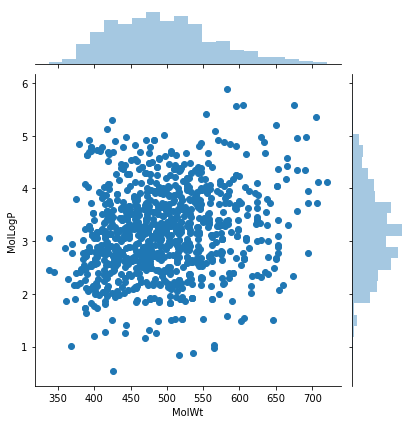

In [74]:
# Molecular weight versus Partition coefficient (octanol/water)
sns.jointplot('MolWt', 'MolLogP', data=tmpdess)

In [0]:
# Concatenating Mol, IC50 and descriptor dataframes
final_dataset = pd.concat([pp[["ID", "Smiles"]], df["SAU Gyr IC50 (µM)"], tmpdess], axis=1)
final_dataset = final_dataset.rename(columns={"SAU Gyr IC50 (µM)":"IC50"})
final_dataset = final_dataset.dropna(how ='any')

### Data cleaning

Finally we have a feature dataset with the compounds information in a vector form, ready for prime time. But before anything else, we have to evaluate which descriptors are correlated, and we should get rid of descriptor $\text{IPC}$ (the magnitude of this feature is insane, e.g. $\sim 10^5$) and those columns with all values $0$.

In [0]:
final_dataset = final_dataset.drop(['Ipc'], axis=1)       # Drop IPC!!!!

headers = list(final_dataset.head(1))                     # Get column names
for col in headers[1:]:                                   # Drop empty columns
    if final_dataset[col].sum() == 0:
        final_dataset = final_dataset.drop([col], axis=1)

Remove correlated descriptors

In [0]:
# Create correlation matrix
corr_matrix = final_dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
for col in to_drop:
    final_dataset.drop(col, axis=1, inplace=True)

In [78]:
# How many descriptors were removed
old = len(descriptors)
new = len(list(final_dataset.head(1))[3:])
print("%i descriptors were removed" % (old - new))

# Update descriptors list
descriptors = list(final_dataset.head(1))[3:]

69 descriptors were removed


The Qualifiers dilema
-------------------------

Now it is time to combine the features and the prediction targets, the $\text{IC50}$s. This dataset includes experimental mesurements from different studies, which in itself it's a challenge if you can to predict $\log{\text{IC50}}$s. But, more importantly we don't have accurate measurements for all compunds in the datatset, some of the reported affinities have qualifiers, like $>400\; \mu M$. For now, let's deal with this problem by flagging the values with ">" and "<" signs and removing these symbols.

In [0]:
# Comment this latter, \
# remove qualifiers using final_dataset[~filters]
pattern = "[<]"
filters = final_dataset.IC50.str.contains(pattern)
final_dataset["left_saturated"] = filters

pattern = "[>]"
filters = final_dataset.IC50.str.contains(pattern)
final_dataset["right_saturated"] = filters

# Reorder dataframe
cols = final_dataset.columns.tolist()
cols = cols[:3] + cols[-2:] + cols[4:]
final_dataset = final_dataset[cols]

Remove the qualifiers, remember there is a new column named _Qualifiers_ that can be used to discriminated the $\text{IC50}$s.

In [0]:
final_dataset['IC50'] = final_dataset['IC50'].str.replace(r'[><]', '')

Log-transform $\text{IC50}$ values and rename set.

In [0]:
final_dataset['IC50'] = final_dataset['IC50'].apply(lambda x: np.log(float(x)))
final_dataset = final_dataset.rename(columns={"IC50": "pIC50"})

Save clean dataset in `Google Drive`.

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Save in Google Drive
final_dataset.to_csv('/content/drive/My Drive/Hack 7/Gyrase/AZ_clean_qual.csv')